In [54]:
#%%
import re
import os
from fears.utils import AutoRate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import pickle
import pandas as pd
import calibration_08302023 as cal

folder_path = '../experiment_data/tk_11092023'

exp_layout = {0:(0,['B','C','D']),
              10**-1:(0,['E','F','G']),
              10**0:(1,['B','C','D']),
              10**1:(1,['E','F','G']),
              10**2:(2,['B','C','D']),
              10**3:(2,['E','F','G'])}

# These functions help with sorting the file names in natural order
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]


rfu30_to_dilution = cal.run()

In [55]:
def get_timeseries(folder_path,plate_num):
    """Takes a folder of excel files and returns a list of plates and a list of data
    Each element in the list corresponds to a plate scan.
    Specify plate num to get the data from a specific excel sheet.

    Args:
        folder_path (str): path to the folder containing the excel files
        plate_num (int): the excel sheet number corresponding to the plate

    Returns:
        list: list of plate objects
        list: list of dictionaries containing the data
    """
    plate_files = os.listdir(folder_path)

    # filter and sort the files
    plate_files = [p for p in plate_files if p.endswith('.xlsx')]
    plate_files.sort(key=natural_keys)

    plates = []
    data = []
    for plate_file in plate_files:
        if plate_file[0] != '~': # ignore temporary files
            path_t = os.getcwd() + os.sep + folder_path + os.sep + plate_file # path to the excel file

            # get a plate object corresponding to the excel file
            p = AutoRate.Plate(path_t,mode='single_measurement',sheet_name=plate_num)
            plates.append(p)

            # put the data in dictionary format with keys corresponding to the well names 
            data.append(p.od_data_to_dict(p.data))
            
    return plates,data

In [56]:
# re-format data into dictionary with keys corresponding to genotypes
# elements of the dicts are timeseries data

mean_dict = {} # mean fluorescence
err_dict = {} # standard error of the mean

cell_count_raw = {}
cell_count_mean = {} # mean cell count
cell_count_err = {} # standard error of the mean
cell_count_log_err = {} # standard error of the mean of the log

# B-D and E-G are replicates

for exp_key in exp_layout.keys():

    # get the data for a specific excel sheet
    plate,data = get_timeseries(folder_path,plate_num=exp_layout[exp_key][0])

    time_list = []

    data_t = np.zeros((3,10))

    for i in range(len(data)):

        dt = plate[i].get_start_time()
        time_list.append(dt)

        # arrange data (replicates,timepoints)
        

        row_indx = 0 # replicate index
        for row in exp_layout[exp_key][1]:
            # col_indx = 0
            # for col in range(10):
                # if col != 2: # ignore column 2 because of experimental mistake
            key = row + str(i+2) # col+2 because we start the experiment at col 2
            data_t[row_indx,i] = data[i][key]
            # col_indx += 1
            row_indx += 1

    mean_dict[exp_key] = np.mean(data_t,axis=0)
    err_dict[exp_key] = np.std(data_t,axis=0)/np.sqrt(3)

    cell_count_data = rfu30_to_dilution(data_t)*10**6
    cell_count_mean[exp_key] = np.mean(cell_count_data,axis=0)
    cell_count_err[exp_key] = np.std(cell_count_data,axis=0)/np.sqrt(3)
    cell_count_log_err[exp_key] = np.std(np.log10(cell_count_data),axis=0)/np.sqrt(3)
    cell_count_raw[exp_key] = cell_count_data

# get the sample times

time = []

t0 = time_list[0]
for t in time_list:
    time.append((t-t0).total_seconds()/60)

time = np.array(time)


In [57]:
plate

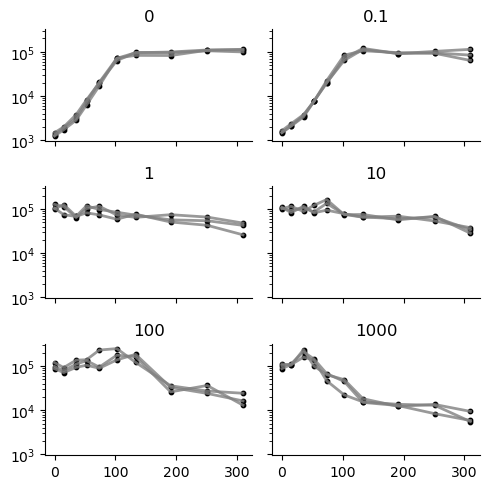

In [58]:
fig,ax_list = plt.subplots(nrows=3,ncols=2,figsize=(5,5),sharex=True,sharey=True)
ax_list = ax_list.flatten()

row_indx = 0
for key in cell_count_mean.keys():
    ax = ax_list[row_indx]
    cell_count_t = cell_count_raw[key]

    for i in range(3):
        ax.plot(time,cell_count_t[i,:],color='gray',alpha=0.8,linewidth=2)
        ax.scatter(time,cell_count_t[i,:],color='k',alpha=1,s=10)
    # ax.errorbar(time,cell_count_mean[key],yerr=cell_count_err[key],fmt='o',label=key)
    # ax.scatter(time,mean_dict[key],label=key)
    # ax.set_xscale('log')
    ax.set_title(key)
    ax.set_yscale('log')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    row_indx += 1

fig.tight_layout()

[[ 3.86128125e-06 -2.32885538e-05]
 [-2.32885538e-05  7.87842436e-04]]
[0.02515702 2.92163654]


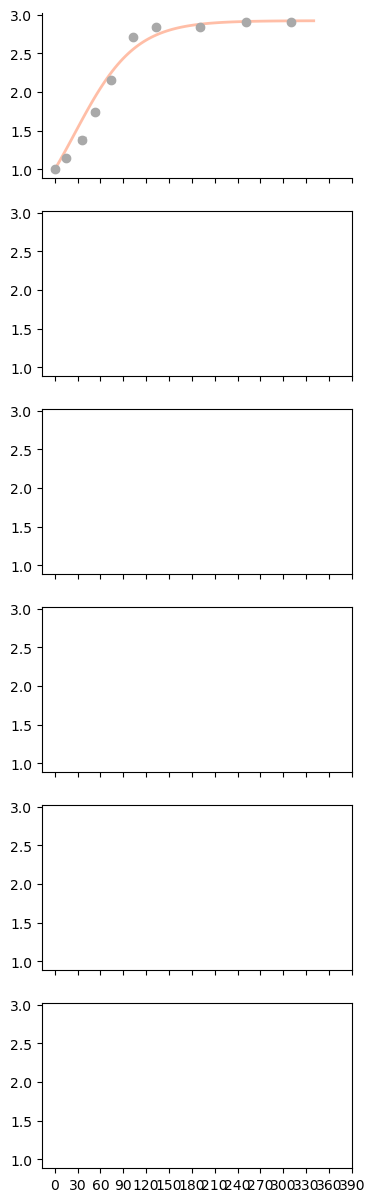

In [71]:
fig,ax_list = plt.subplots(nrows=6,figsize=(4,15),sharex=True,sharey=True)

cmap = mpl.colormaps['viridis']

# def drug_free_growtheq(N,t,K,beta,cc):
#     dydt = K*(1-np.exp(-beta*t))*N*(1-N/cc)
#     return dydt

def growth_diffeq(N,t,K,Kss,alpha,beta,cc):

    dydt = (K*(1-np.exp(-beta*t))-Kss*(1-np.exp(-alpha*t)))*N*(1-N/cc)

    return dydt

def growth_sol(t,y0,K,Kss,alpha,beta,cc):
    y = odeint(growth_diffeq,y0,t,args=(K,Kss,alpha,beta,cc))
    return y[:,0]

# def growth_sol_drug_free(t,y0,K,beta,cc):
#     y = odeint(drug_free_growtheq,y0,t,args=(K,beta,cc))
#     return y[:,0]

# cc = 7
# K = 0.014

xfit = np.linspace(0,np.max(time+30),100)

row_indx = 0

# estimate parameters for first condition
key = 0

y = np.log10(cell_count_mean[key])

ax = ax_list[row_indx]

ax.errorbar(time,y,yerr=cell_count_log_err[key],fmt='o',color='darkgrey',capsize=3)

# p0 = [y[0],0.1,0.1,6] # y0, K, beta, cc
# bounds = [[1,0,0,0],[7,100,10,10]]

# p0 = [0.1,0.1,6] # K, beta, cc
# bounds = [[0,0,0],[100,10,10]]

p0 = [0.1,6] # K, cc
bounds = [[0,0],[10,10]]

# # beta = 1000
# K = 0.017
y0 = y[0]
alpha = 0
Kss = 0
beta = 10**4

popt,pcov = curve_fit(lambda time, K, cc: growth_sol(time,y0,K,Kss,alpha,beta,cc),
                    time,y,p0=p0,maxfev=10000,bounds=bounds,sigma=cell_count_log_err[key])

# y0 = popt[0]
# K = popt[1]
# beta = popt[2]
# cc = popt[3]

# beta = popt[0]
# # beta = popt[1]
# cc = popt[1]

# cc = 5
# beta = 0.15

K = popt[0]
cc = popt[1]

yfit = growth_sol(xfit,y0,K,Kss,alpha,beta,cc)

resid = np.sum((y-growth_sol(time,y0,K,Kss,alpha,beta,cc))**2)

ax.plot(xfit,yfit,'-',color='coral',linewidth=2,alpha=0.5)

err = np.sqrt(np.diag(pcov))

# ax.annotate('K = ' + str(np.round(K*60,3)) + " ± " + f"{err[1]:.2E}" + '\n' + 
#             'cc = ' + str(np.round(cc,3)) + " ± " + f"{err[2]:.2E}" + '\n'
#             '$RSS$ = ' + str(np.round(resid,3)), xy=(0.5,0.1),xycoords='axes fraction',fontsize=10)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xticks(np.arange(0,400,30))
ax.set_xticklabels(np.arange(0,400,30))


# for key in list(cell_count_mean.keys())[1:]:
#     ax = ax_list[row_indx]

#     y = np.log10(cell_count_mean[key])

#     ax.errorbar(time,y,yerr=cell_count_log_err[key],fmt='o',color='darkgrey',capsize=3)

#     p0 = [2,0.1,0.1]
#     bounds = [[1,0,0],[7,1,1]]

#     popt,pcov = curve_fit(lambda time, y0, Kss, alpha: growth_sol(time,y0, K,Kss,alpha,cc),
#                         time,y,p0=p0,maxfev=10000,bounds=bounds,sigma=cell_count_log_err[key])
    
#     y0 = popt[0]
#     Kss = popt[1]
#     alpha = popt[2]
#     yfit = growth_sol(xfit,y0,K,Kss,alpha,cc)

#     resid = np.sum((y-growth_sol(time,y0,K,Kss,alpha,cc))**2)

#     ax.plot(xfit,yfit,'-',color='coral',linewidth=2,alpha=0.5)

#     err = np.sqrt(np.diag(pcov))

#     ax.annotate('Genotype: ' + str(key) + '\n' + 'Kss = ' + str(np.round(Kss*60,3)) + " ± " + f"{err[1]:.2E}" + '\n' + 
#                 'alpha = ' + str(np.round(alpha,3)) + " ± " + f"{err[2]:.2E}" + '\n'
#                 '$RSS$ = ' + str(np.round(resid,3)), xy=(0.05,0.1),xycoords='axes fraction',fontsize=10)
    
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)

#     row_indx += 1

# ax_list[-1].set_xlabel('Time (min)',fontsize=12)
# ax_list[2].set_ylabel('Normalized cell count (log10)',fontsize=12)

print(pcov)
print(popt)

In [73]:
cell_count_mean[1][0]/cell_count_mean[0][0]

82.1479261200134